# Garbage Classification

![Garbage Bins](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwebstockreview.net%2Fimages%2Fgarbage-clipart-wastebin-16.png&f=1&nofb=1)


Garbage segregation involves separating wastes according to how it's handled or processed. It's important for recycling as some materials are recyclable and others are not.

In this project I will use PyTorch for classifying garbage into various categories like metal, paper, glass, plastic, cardboard and trash. The dataset I am going to use is free to use and [available on Kaggle](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification).

While working on this project I will try different neural network architectures, different hyperparameters and different variations of dataset. However, for the sake of the completeness of the notebook, I won't be putting everything here. I will mention different results and the known reasons behind them in different places throughout the notebook.

Please note that, due to magic commands and iPython's capabilities (printing out a variable by just typing the variable) this notebook is not compatible with ordinary Python. Be aware of this if you are going to export it as `.py` file.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset_path  = "../resources/garbage_dataset"

Create a dataset from given folder. Pytorch's [ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html) method makes our job really easy in this case. `dataset.classes` shows the available categories.

In [3]:
dataset = ImageFolder(dataset_path)
num_classes = len(dataset.classes)
dataset.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

## Transformations & Augmentation

Increasing the number of inputs helps for our model to learn better. I won't be increasing the number of images in our filesystem, but PyTorch's transformations will help us to increase it by giving out random flipped or random rotated images from loaders.

Also, neural networks tend to learn better when the pixel values are not between $0-255$ but $0-1$, although this time I will normalize the pixel values by applying normalization to the images by the following formula. Mean and standard deviation values belongs to [ImageNet](https://www.image-net.org/index.php). I could have calculated from our own dataset, but this also works fine for us.

$$
    output = \frac{input - std}{mean}
$$

In [4]:
def show_samples(ds, idxs):
    """
    Takes dataset, and number of samples to show. Shows them on a plot with their
    corresponding labels.
    """
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))

    for i, idx in enumerate(idxs):
        img, label = ds[idx]

        if isinstance(img, torch.Tensor):
            axes[i].imshow(img.permute(1, 2, 0))
        else:
            axes[i].imshow(img)

        axes[i].set_title(f"Label: {dataset.classes[label]}")
        axes[i].axis("off")

    plt.show()

Show samples before transformations being applied to the dataset.

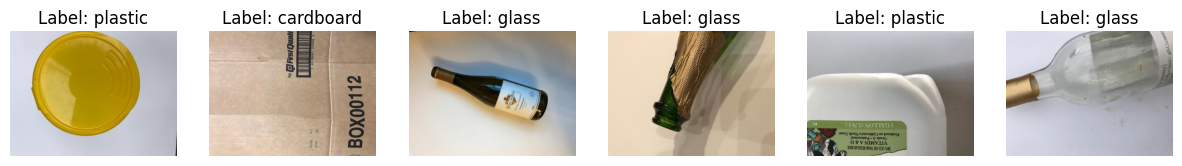

In [5]:
num_samples = 6
idxs = torch.randint(len(dataset), size=(num_samples,))
show_samples(dataset, idxs)

Show the same samples after the transformations applied.

Please ignore the warning message from matplotlib. These warning messages occurs because after normalization, some of the pixel values goes out the range, such as they become negative values. That's why matplotlib clips those invalid values.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


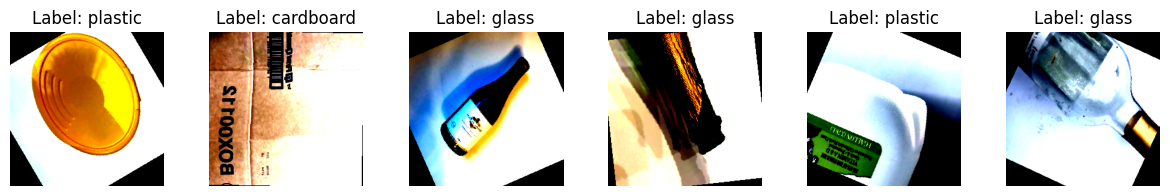

In [6]:
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

transformations = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((256, 256), antialias=True),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(40),
    v2.Normalize(imagenet_mean, imagenet_std)
])

dataset = ImageFolder(dataset_path, transform=transformations)
show_samples(dataset, idxs)

## Loading and Splitting Data for Training, Validation and Testing

I will use 85% of the total data for training, 10% for validation and 5% for testing. These numbers may vary in different applications, but the common convention is that size of the training should be much larger than the rest. Since validation will tell me where to stop before overfitting, I want it to be bigger than test dataset.

In [7]:
# I will use a random seed in order to get consistent results in every ty
# However, it's not a big deal, so you can turn it off if you want!
random_seed = 42
generator = torch.manual_seed(random_seed)

In [8]:
train_ds, val_ds, test_ds = random_split(dataset, [0.85, 0.10, 0.05], generator=generator)
print(f"Train set size: {len(train_ds)}")
print(f"Validation set size: {len(val_ds)}")
print(f"Test set size: {len(test_ds)}")

Train set size: 2148
Validation set size: 253
Test set size: 126


In [9]:
# Hyperparameters
batch_size = 32
num_workers = 4

In [10]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=num_workers)
val_dl = DataLoader(val_ds, batch_size, num_workers=num_workers)
test_dl = DataLoader(test_ds, batch_size, num_workers=num_workers)

In [11]:
def show_batch(dl):
    """
    Shows the first batch from a given DataLoader.
    """
    images, labels = next(iter(dl))
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


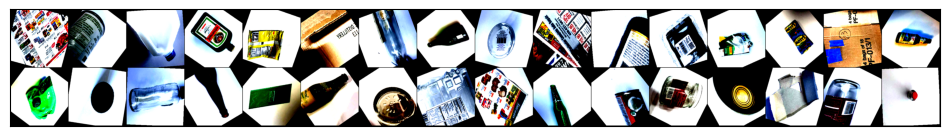

In [12]:
show_batch(train_dl)

## Model

Model base will help us to train and validate our model. Thanks to this way, we won't need to write everything inside the training loop. Later on, we will create our architecture while inheriting this base class.

In [13]:
def calculate_accuracy(outputs, labels):
    """
    Calculates the accuracy by comparing the outputs with the true labels.
    """
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        """
        Takes the training batch, calculates loss and accuracy.
        """
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = calculate_accuracy(out, labels)
        return loss, acc

    def validation_step(self, batch):
        """
        Takes the validation batch, calculates loss and accuracy. Returns a dictionary of loss and accuracy.
        """
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = calculate_accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        """
        Takes the outputs from all the batches, and calculates average loss and accuracy.
        Returns a dictionary of average loss and accuracy.
        """
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        """
        Takes epoch number, and results after both training and validation. Prints out the values.
        """
        print("Epoch {}: train_acc: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch + 1, result["train_acc"], result["train_loss"], result["val_loss"], result["val_acc"]))

### MyNet

The network so called `MyNet` below is made up from 5 convolutional layers for feature extraction, and for the classification usual linear layers have been used. The whole architecture looks like [AlexNet](https://en.wikipedia.org/wiki/AlexNet) who won several contests like the first ImageNet contest.

In [14]:
class MyNet(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


summary(MyNet(len(dataset.classes)), (3, 256, 256));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 63, 63]          23,296
|    └─ReLU: 2-2                         [-1, 64, 63, 63]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 31, 31]          --
|    └─Conv2d: 2-4                       [-1, 192, 31, 31]         307,392
|    └─ReLU: 2-5                         [-1, 192, 31, 31]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 15, 15]         --
|    └─Conv2d: 2-7                       [-1, 384, 15, 15]         663,936
|    └─ReLU: 2-8                         [-1, 384, 15, 15]         --
|    └─Conv2d: 2-9                       [-1, 256, 15, 15]         884,992
|    └─ReLU: 2-10                        [-1, 256, 15, 15]         --
|    └─Conv2d: 2-11                      [-1, 256, 15, 15]         590,080
|    └─ReLU: 2-12                        [-1, 256, 15, 15]   

### StarkNet

The architecture below utilizes mostly [Batch Normalization](https://arxiv.org/abs/1502.03167) instead of Max Pooling. It's also one of the networks I have used for this dataset. It gives slightly better results compared to `MyNet`. Batch Normalization's intention is actually not give better results but [improve the speed of the training with fewer steps](https://arxiv.org/abs/1502.03167). I'm thinking for this dataset, I'm a bit lucky for getting a better accuracy.

In [15]:
class StarkNet(ImageClassificationBase):
    def __init__(self, num_classes):
        super(StarkNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=3),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=3),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))

        self.classifier = nn.Sequential(
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

summary(StarkNet(len(dataset.classes)), (3, 256, 256));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 10, 10]         --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        9,472
|    └─BatchNorm2d: 2-2                  [-1, 64, 128, 128]        128
|    └─Conv2d: 2-3                       [-1, 128, 66, 66]         73,856
|    └─BatchNorm2d: 2-4                  [-1, 128, 66, 66]         256
|    └─Conv2d: 2-5                       [-1, 256, 35, 35]         295,168
|    └─BatchNorm2d: 2-6                  [-1, 256, 35, 35]         512
|    └─Conv2d: 2-7                       [-1, 512, 20, 20]         1,180,160
|    └─BatchNorm2d: 2-8                  [-1, 512, 20, 20]         1,024
|    └─ReLU: 2-9                         [-1, 512, 20, 20]         --
|    └─MaxPool2d: 2-10                   [-1, 512, 10, 10]         --
├─AdaptiveAvgPool2d: 1-2                 [-1, 512, 2, 2]           --
├─Sequential: 1-3                        [-1, 6]            

### Resnet

In order to see what we can achieve with a near perfect model, I will also finetune Resnet50 and use it. It's not unlikely to see **95%** accuracy.

In [16]:
import torchvision.models as models


class ResNet(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.network = models.resnet50(weights="IMAGENET1K_V2")
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

summary(ResNet(len(dataset.classes)), (3, 256, 256));

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 6]                   --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 128, 128]        128
|    └─ReLU: 2-3                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 64, 64]          --
|    └─Sequential: 2-5                   [-1, 256, 64, 64]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 64, 64]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 64, 64]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 64, 64]         70,400
|    └─Sequential: 2-6                   [-1, 512, 32, 32]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 32, 32]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 32, 32]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 32, 32] 

### Porting to GPU

GPUs tend to perform faster calculations than CPU. Although my machine doesn't have a GPU, I will still write the code so that we can utilize GPU if we have in environments like Google Colab. Using a custom Data Loader will help us when we need to move the images to device memory. This is again in order to reduce the complexity in the training loop.

In [17]:
def get_default_device():
    """
    Returns the utilized device in the host machine. If you are using CUDA and the program chooses CPU,
    make sure you installed PyTorch's cuda version, and necessary cuda kernels.
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """
    Moves data to given device
    """
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]

    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cpu')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

## Training the Model

Training a model in a personal computer without a GPU takes time, and it's even harder if you are unsure about the architecture of your model, the hyperparameters like learning rate and the optimizer you use. Therefore, I implemented two functions for saving and loading a model. Note that, we are saving not just model but optimizer, epoch number and the history.

History is a list of dictionaries which stores loss and accuracy values of train and validation.

In [20]:
def save_checkpoint(model, optimizer, epoch, history, save_path):
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "history": history
    }, save_path)


def load_checkpoint(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    history = checkpoint["history"]
    return model, optimizer, epoch, history

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, optimizer, train_loader, val_loader, history=None, save_path="./m.pth"):
    if not history:
        history = []

    pre_epoch = len(history)

    for epoch in range(pre_epoch, epochs + pre_epoch):
        model.train()
        train_losses = []
        train_accs = []

        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Update history
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

        # Save the current progress
        save_checkpoint(model, optimizer, epoch, history, save_path)

    return history

These parameters may vary depending on the network and dataset, for this dataset and for this architecture these values do okay. For example one using a standard learning rate (0.001) didn't yield a proper result, because model was struggling to learn. That's why I decreased it by time and tried again and again.

In [22]:
# Hyperparameters
num_epochs = 30
lr = 5.5e-5

I won't be training the network again, because I already have trained and saved it. That's why I will load from my disk, and continue with that. Since we also saved the history, we still will be able to loss and accuracy graphs. If you want to train it, feel free the run the code below!

In [ ]:
model = to_device(MyNet(num_classes), device)
optimizer = torch.optim.Adam(model.parameters(), lr)
history = fit(num_epochs, model, optimizer, train_dl, val_dl, save_path="../models/mynet-v1.pth")

In [23]:
model = to_device(MyNet(num_classes), device)
optimizer = torch.optim.Adam(model.parameters(), lr)
model, optimizer, num_epochs, history = load_checkpoint(model, optimizer, "../models/mynet-v1.pth")

To be able to understand the progress, it's a good idea to plot loss and accuracy over epochs. We can get insight about the learning progress of our model. For example, down below, we can see the `validation loss` is near minimum, and it seems it won't be going to decrease even more. If we had trained the model for not **30** epochs but **50** epochs, we would see the dramatic increase for `validation loss`. It means that our model is starting to learn by heart. It's no coincidence that the `training loss` is always decreasing, that's the point of using an optimizer. It will almost always choose the parameters that will result in less error. Therefore, we need more "fair" method to see progress, which is `validation dataset`. We do not upgrade the model parameters while predicting over validation dataset, with this way model never learns from them

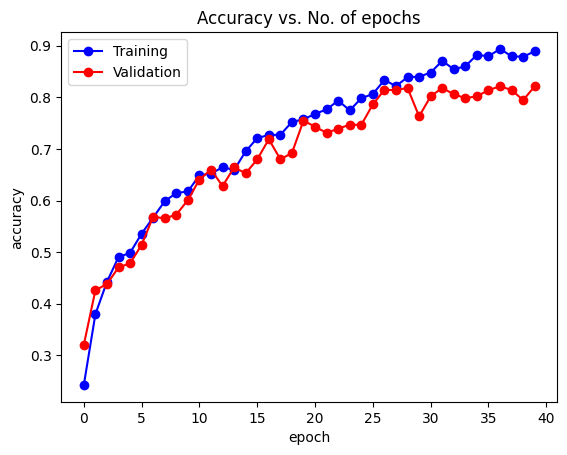

In [24]:
def plot_accuracies(history):
    train_acc = [x["train_acc"] for x in history]
    val_acc = [x["val_acc"] for x in history]
    plt.plot(train_acc, "-bo")
    plt.plot(val_acc, "-ro")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

plot_accuracies(history)

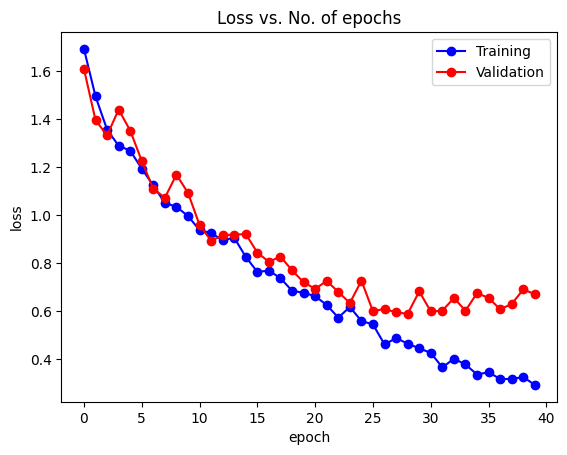

In [25]:
def plot_losses(history):
    train_losses = [x.get("train_loss") for x in history]
    val_losses = [x["val_loss"] for x in history]
    plt.plot(train_losses, "-bo")
    plt.plot(val_losses, "-ro")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of epochs")

plot_losses(history)

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np


def show_confusion_matrix(model, test_dl, classes):
    model.eval()
    y_pred = []
    y_true = []

    for images, labels in test_dl:
        out = model(images)
        prob, preds  = torch.max(out, dim=1)
        y_pred.extend(preds)
        y_true.extend(labels)

    accuracy = 100 * sum(int(pred == true) for pred, true in zip(y_pred, y_true)) / len(y_pred)
    print(f"Accuracy: {round(accuracy, 3)}")

    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                         index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (8,5))
    sn.heatmap(df_cm, annot=True)

Accuracy: 76.19


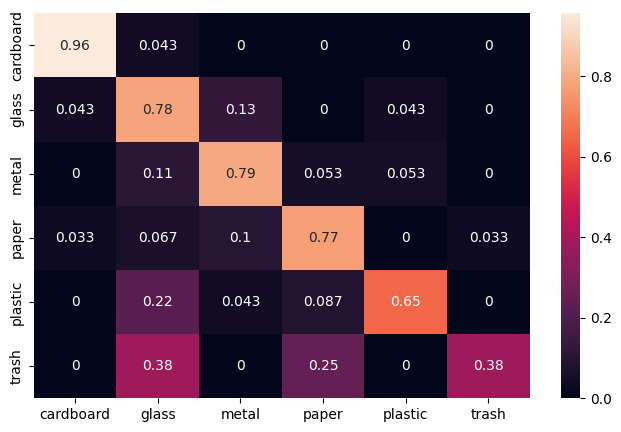

In [27]:
show_confusion_matrix(model, test_dl, dataset.classes)

## Visualizing Predictions

Let's grab some pictures from our test dataset, see the predictions vs. true labels.

In [28]:
def predict_image(model, img):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    prob, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

def show_predictions(model, ds, num_samples):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for i in range(num_samples):
        row, col = divmod(i, 3)
        index = torch.randint(len(ds.dataset), size=(1,)).item()
        img, label = ds.dataset[index]
        pred = predict_image(model, img)
        axes[row, col].imshow(img.permute(1, 2, 0))
        axes[row, col].set_title(f"Label: {ds.dataset.classes[label]} | Pred: {pred}")
        axes[row, col].axis("off")

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


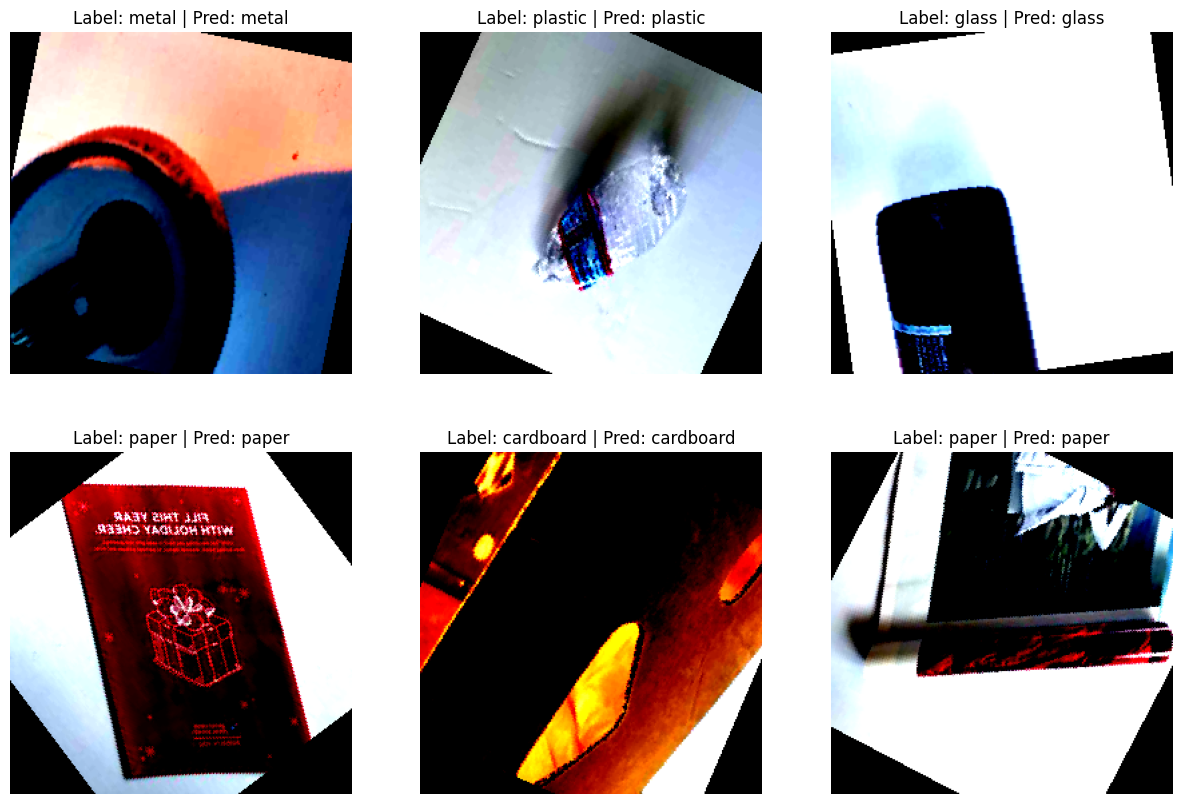

In [29]:
show_predictions(model, test_ds, 6)

### External Images

In [30]:
import urllib.request
from PIL import Image
from pathlib import Path

Download some external images and save them into specified path.

In [31]:
urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Google-Cardboard.jpg/1200px-Google-Cardboard.jpg",
                           "../resources/external-images/cardboard.jpg")
urllib.request.urlretrieve("https://upload.wikimedia.org/wikipedia/commons/a/a8/Empty_tin_can2009-01-19.jpg",
                           "../resources/external-images/can.jpg")
urllib.request.urlretrieve("https://www.wpt-nl.com/images/module_image/img1_800_600_1593777835.jpg",
                           "../resources/external-images/paper-trash.jpg")

('../resources/external-images/paper-trash.jpg',
 <http.client.HTTPMessage at 0x7f0f47dc4350>)

In [32]:
def predict_external_image(image_name):
    transformations = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((256, 256), antialias=True),
        v2.Normalize(imagenet_mean, imagenet_std)
    ])
    image = Image.open(Path(f"../external-images/{image_name}"))
    example_image = transformations(image)
    plt.imshow(image)
    plt.title(f"This is an image of {predict_image(model, example_image)}.")
    plt.axis("off")

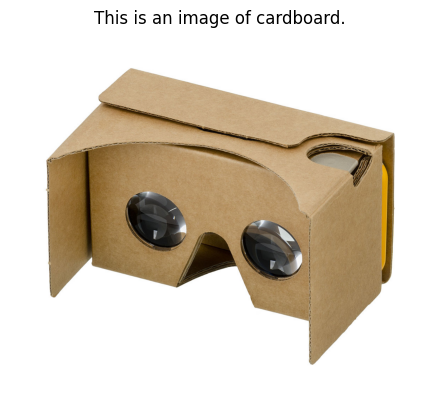

In [33]:
predict_external_image("../resources/external-images/cardboard.jpg")

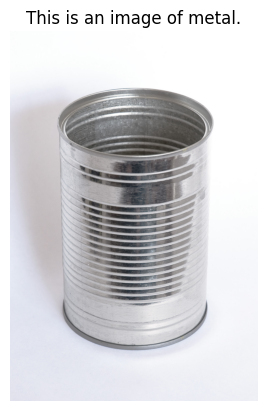

In [34]:
predict_external_image("../resources/external-images/can.jpg")

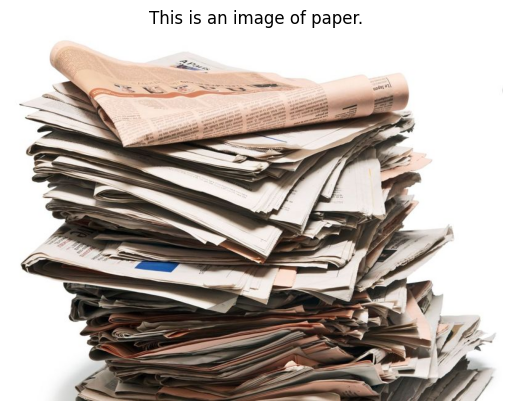

In [35]:
predict_external_image("../resources/external-images/paper-trash.jpg")

## Conclusion

Our model is able to classify garbage with around **75-80% accuracy**! It's great to see the model's predictions on the test set. It works alright on external images too.

However, it's worth noting that there is still a big gap to improve. I don't think this improvements will be mainly on network, but I think they will be on dataset. When you look at the dataset, we always see the images with white background. This situtation causes for our model to predict everything with brownish, yellowish color as cardboard. This is one of the things I realized after investing hours into this project. It's possible to merge the dataset with other datasets from Kaggle, we can both increase the number of data and variety.